<a href="https://colab.research.google.com/github/xkumachii/pneumonia/blob/MERGER/pneumonia_playaround_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras import Model, Input, models, layers
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2

In [2]:
! pip install -q kaggle
from google.colab import files

In [3]:
# 1.) check your kaggle account 
# 2.) go to edit profile
# 3.) create a new api token
# 4.) upload your kaggle.json file here
# 5.) for any retesting, keep your json file, and do not regenerate your api token unless absolutely needed
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kumachii","key":"f8cd305bf4afae205ea340858ca16b92"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:41<00:00, 33.8MB/s]
100% 2.29G/2.29G [00:41<00:00, 60.0MB/s]


In [6]:
!ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [7]:
import zipfile
zip_ref = zipfile.ZipFile("chest-xray-pneumonia.zip", "r")
zip_ref.extractall("files")
zip_ref.close()

In [8]:
!ls

chest-xray-pneumonia.zip  files  kaggle.json  sample_data


# X-ray Image Classification 

This notebook will demonstrate the diagnosis of pneumonia, and different types of pneumonia using Convolutional Neural Networks. 

The dataset we are working with is of various X-ray images of Chinese pediatric patients' lungs, sourced from Kaggle.


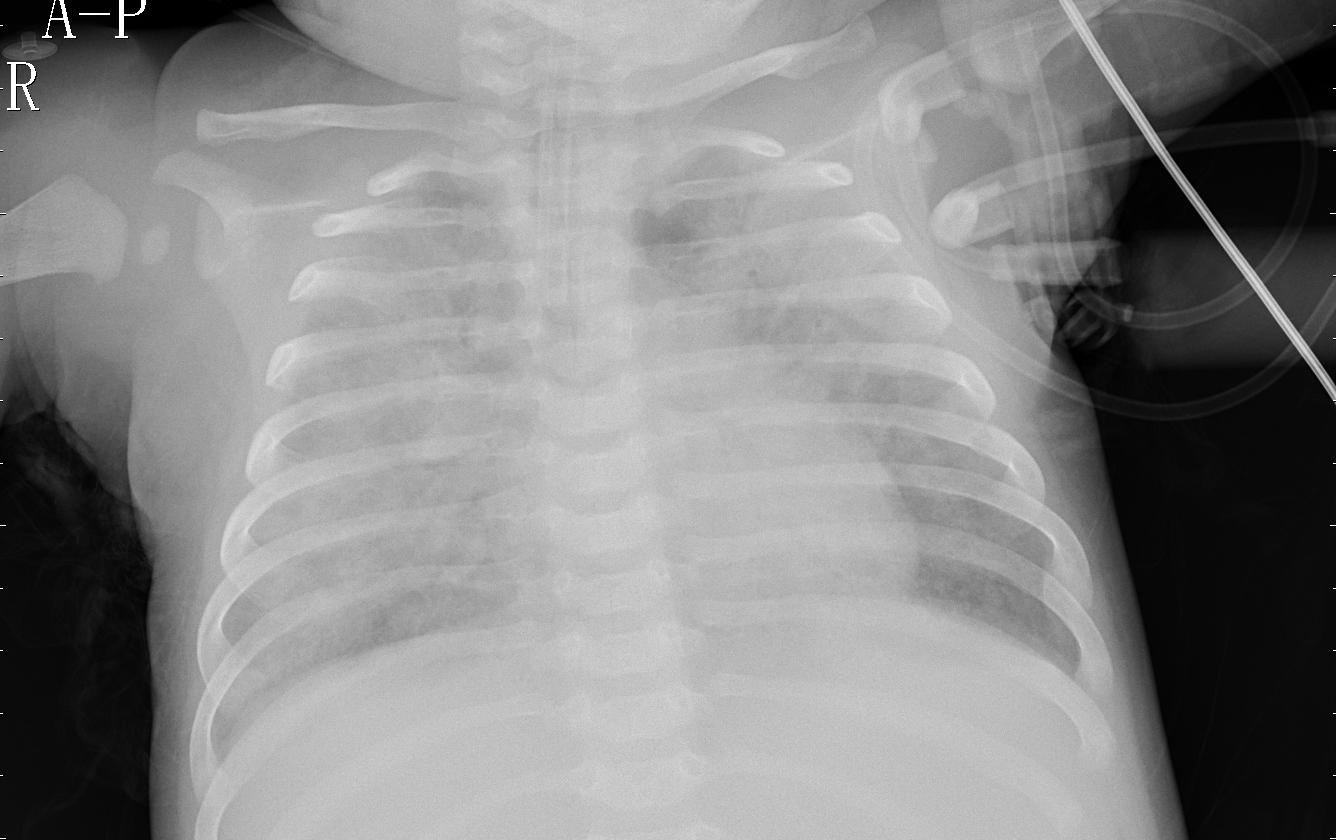

In [9]:
# The local path to the target image
img_path = "/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg"

display(Image(img_path))

Stuff about preprocessing

# Binary Classification

For our first model, we will first take the images from our drive, and preprocess them into data that can be fed into a CNN.

For this section, we will focus on predicting whether a patient has pneumonia or not.

In [10]:
def load_data(path):

  imgs = []
  labels = np.array([])

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      # To reduce training costs, the images are resized to 200x200.
      img = image.load_img(temp_path + "/" + f, target_size=(150,150))
      x = image.img_to_array(img)
      imgs.append(x)
      labels = np.append(labels, [int(dir == 'PNEUMONIA')])

      # to check progress:
      
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1
   

  imgs = np.asarray(imgs)
  # normalize our data from values 0-1
  imgs /= 255
  print(imgs.shape) # left there for debug
  return imgs, labels


In [11]:
# validation data was used as training data to debug things
X_train, y_train = load_data("/content/files/chest_xray/train")
X_test, y_test = load_data("/content/files/chest_xray/test")
# X_val, y_val = load_data("/content/files/chest_xray/val")

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
(5216, 150, 150, 3)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 150, 150, 3)


In [12]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

## CNN

We will be testing our data on a simple CNN, with a dropout rate of 0.5.

In [13]:
K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [15]:
# recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# f1
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [17]:
batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

history = model.fit(gen_data,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,validation_data=gen_test,validation_steps=X_test.shape[0]//batch_size)

Epoch 1/20
163/163 [==============================] - 25s 154ms/step - loss: 0.5726 - accuracy: 0.7400 - f1_m: 0.8431 - precision_m: 0.7538 - recall_m: 0.9700 - val_loss: 0.5318 - val_accuracy: 0.7599 - val_f1_m: 0.8204 - val_precision_m: 0.7521 - val_recall_m: 0.9076
Epoch 2/20
163/163 [==============================] - 25s 155ms/step - loss: 0.4508 - accuracy: 0.7908 - f1_m: 0.8639 - precision_m: 0.8223 - recall_m: 0.9215 - val_loss: 0.5342 - val_accuracy: 0.7516 - val_f1_m: 0.8238 - val_precision_m: 0.7299 - val_recall_m: 0.9561
Epoch 3/20
163/163 [==============================] - 25s 153ms/step - loss: 0.3838 - accuracy: 0.8238 - f1_m: 0.8831 - precision_m: 0.8640 - recall_m: 0.9151 - val_loss: 0.3646 - val_accuracy: 0.8536 - val_f1_m: 0.8822 - val_precision_m: 0.8623 - val_recall_m: 0.9076
Epoch 4/20
163/163 [==============================] - 25s 152ms/step - loss: 0.3584 - accuracy: 0.8449 - f1_m: 0.8943 - precision_m: 0.8805 - recall_m: 0.9179 - val_loss: 0.3815 - val_accuracy:

In [18]:
'''
batch_size = 128

traingen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True

)

testgen = ImageDataGenerator(rescale=1./255)

train_generator = traingen.flow_from_directory(
        "/content/files/chest_xray/train",
        target_size=(150, 150),
        classes=["NORMAL", "PNEUMONIA"],
        batch_size=32,
        class_mode='binary')
validation_generator = testgen.flow_from_directory(
        "/content/files/chest_xray/test",
        target_size=(150, 150),
        classes=["NORMAL", "PNEUMONIA"],
        batch_size=32,
        class_mode='binary')

# todo: save the augmented data to a separate directory named: test_aug

history = model.fit(train_generator,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,validation_data=validation_generator,validation_steps=X_test.shape[0]//batch_size)
'''

'\nbatch_size = 128\n\ntraingen = ImageDataGenerator(\n    rescale= 1./255,\n    rotation_range =45,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip = True\n\n)\n\ntestgen = ImageDataGenerator(rescale=1./255)\n\ntrain_generator = traingen.flow_from_directory(\n        "/content/files/chest_xray/train",\n        target_size=(150, 150),\n        classes=["NORMAL", "PNEUMONIA"],\n        batch_size=32,\n        class_mode=\'binary\')\nvalidation_generator = testgen.flow_from_directory(\n        "/content/files/chest_xray/test",\n        target_size=(150, 150),\n        classes=["NORMAL", "PNEUMONIA"],\n        batch_size=32,\n        class_mode=\'binary\')\n\n# todo: save the augmented data to a separate directory named: test_aug\n\nhistory = model.fit(train_generator,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,validation_data=validation_generator,validation_steps=X_test.shape[0]//batch_size)\n'

In [19]:
model.evaluate_generator(gen_test, 50, workers=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.2668472230434418,
 0.9022436141967773,
 0.9257704019546509,
 0.8937776684761047,
 0.963170051574707]

In [20]:
for i in range (0, 400):
  preds = model.predict(np.expand_dims(X_test[i], axis=0))
  print("Chance of Pneumonia:", (preds))

Chance of Pneumonia: [[0.3708285]]
Chance of Pneumonia: [[0.30887014]]
Chance of Pneumonia: [[0.33642444]]
Chance of Pneumonia: [[0.15582612]]
Chance of Pneumonia: [[0.47357583]]
Chance of Pneumonia: [[0.62700015]]
Chance of Pneumonia: [[0.3469137]]
Chance of Pneumonia: [[0.24832556]]
Chance of Pneumonia: [[0.15411976]]
Chance of Pneumonia: [[0.89986587]]
Chance of Pneumonia: [[0.05160846]]
Chance of Pneumonia: [[0.20581351]]
Chance of Pneumonia: [[0.09684029]]
Chance of Pneumonia: [[0.18930556]]
Chance of Pneumonia: [[0.9034052]]
Chance of Pneumonia: [[0.47082293]]
Chance of Pneumonia: [[0.05376955]]
Chance of Pneumonia: [[0.0555529]]
Chance of Pneumonia: [[0.11750118]]
Chance of Pneumonia: [[0.85869396]]
Chance of Pneumonia: [[0.2091337]]
Chance of Pneumonia: [[0.5963125]]
Chance of Pneumonia: [[0.19424015]]
Chance of Pneumonia: [[0.55005383]]
Chance of Pneumonia: [[0.2930375]]
Chance of Pneumonia: [[0.19683559]]
Chance of Pneumonia: [[0.11079249]]
Chance of Pneumonia: [[0.20916785]]

In [21]:
# our code has a 91% validation accuracy on test data

In [22]:
'''
#img_array = preprocess_input(get_img_array("/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg", size=(150,150)))

img_path = "/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg"

# preds = model.predict(np.expand_dims(X_test[340], axis=0))

img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = preprocess_input(x)


preds = model.predict(img)


print("Predicted:", (preds))
'''

'\n#img_array = preprocess_input(get_img_array("/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg", size=(150,150)))\n\nimg_path = "/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg"\n\n# preds = model.predict(np.expand_dims(X_test[340], axis=0))\n\nimg = image.load_img(img_path, target_size=(150,150))\nx = image.img_to_array(img)\nx = np.expand_dims(x, axis=0)\nimg = preprocess_input(x)\n\n\npreds = model.predict(img)\n\n\nprint("Predicted:", (preds))\n'

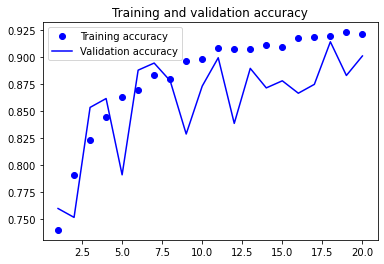

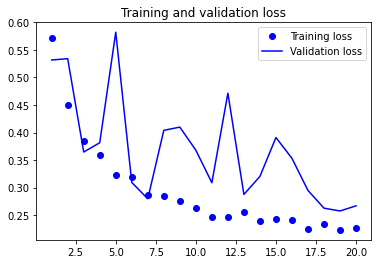

In [23]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

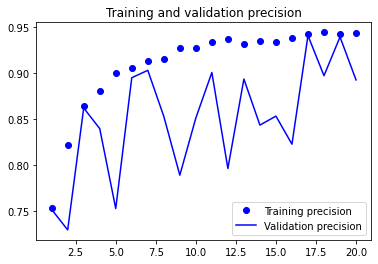

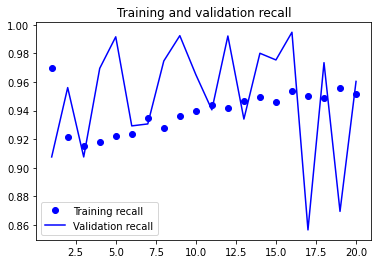

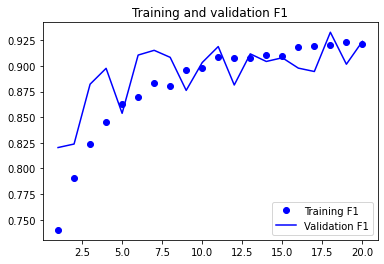

In [24]:
precision = history.history['precision_m']
recall = history.history['recall_m']
f1 = history.history['f1_m']
val_precision = history.history['val_precision_m']
val_recall = history.history['val_recall_m']
val_f1 = history.history['val_f1_m']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend()

plt.show()

In [25]:
# model.compile(optimizer='rmsprop',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# model.fit(X_val, y_val, epochs=15, batch_size=32) #this line is for debug purposes

# things to consider
# cost function for false negatives and false positives
# slightly unbalanced data set -- oversample? undersample? both?
# three-way classification section
shit faggot

SyntaxError: ignored

We graph our stuff here

##Imbalanced Data

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
print(class_weight)

In [ ]:
class_weight = {0:1.94, 1:0.67}
print(class_weight)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test),class_weight=class_weight)

In [ ]:
model= tf.keras.applications.Xception(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=max,
    classes = 2,
    classifier_activation="softmax",
)

In [ ]:
opt=tf.keras.optimizers.Adam(
    learning_rate=0.015,
    name="Adam",

)

In [ ]:
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test),class_weight=class_weight)

In [ ]:
!pip install imblearn 

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)

#X_train_S, y_train_S = smote.fit_sample(X_train,y_train)


print(X_train[1])

In [ ]:
from collections import Counter
print(Counter(y_train_S))

# HEAT MAPS!

In [29]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

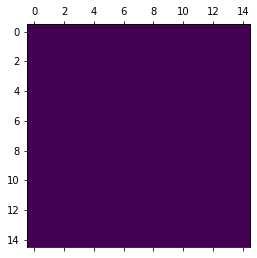

In [58]:
last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]



last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
# heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.matshow(heatmap)

In [59]:
# todo: fix potential problem for displaying the activation of the conv2d_3 layer.

img_path = "/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg"
img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = preprocess_input(x)

last_conv_layer = model.get_layer('conv2d_3')
last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

classifier_input = Input(shape=last_conv_layer.output.shape[1:])
cl_in = classifier_input

for i in [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]:
  cl_in = model.get_layer(i)(cl_in)

classifier_model = Model(classifier_input, cl_in)

with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img)
  tape.watch(last_conv_layer_output)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

pooled_grads = K.mean(grads, axis=(0, 1, 2))

pooled_grads_value = pooled_grads.numpy() 

conv_layer_output_value = last_conv_layer_output.numpy()[0]

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [54]:
heatmap = np.maximum(heatmap, 0) / np.max(heatmap) # this might be a problem.

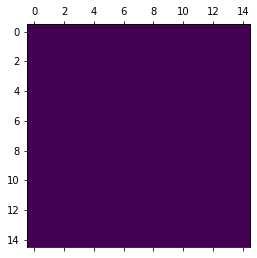

In [57]:
plt.matshow(heatmap)
plt.show()

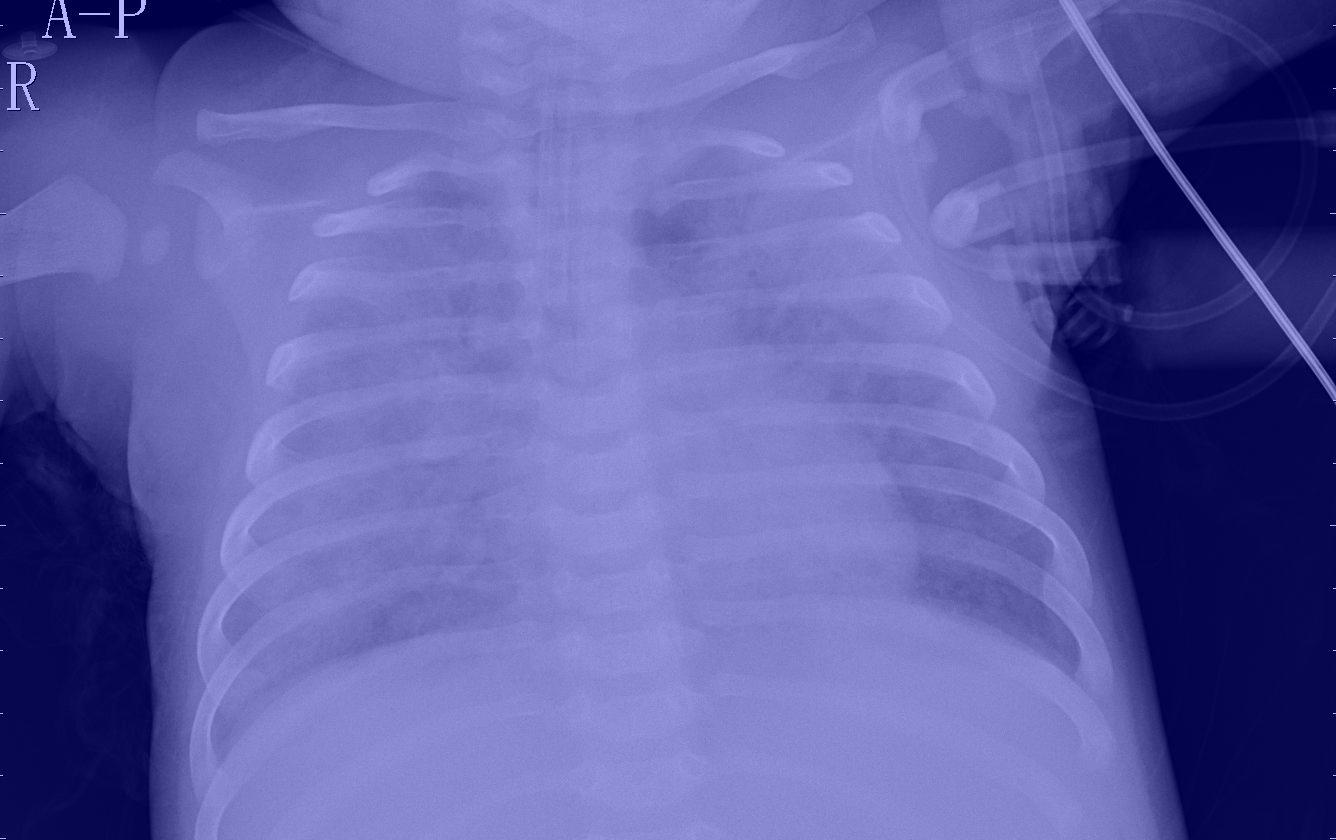

In [35]:
# We load the original image
img = tf.keras.preprocessing.image.load_img(img_path)
img = tf.keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "pneumonia_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

# Three-Way Classification

We will now be processing our data such that we will also be taking into consideration, the type of pneumonia one can be diagnosed with -- bacterial and viral.

In [70]:
def load_data_2(path):
  imgs = []
  labels = []

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      # To reduce training costs, the images are resized to 200x200.
      img = image.load_img(temp_path + "/" + f, target_size=(150,150))
      x = image.img_to_array(img)
      imgs.append(x)

      # one-hot encoded labels
      labels.append([int(not ('bacteria' in f or 'virus' in f)), int('bacteria' in f), int('virus' in f)])


      # to check progress:
      
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1

      

  imgs = np.asarray(imgs)
  labels = np.asarray(labels)
  # normalize our data from values 0-1
  imgs /= 255
  print(imgs.shape) # left there for debug
  return imgs, labels

In [71]:
X_train, y_train = load_data_2("/content/files/chest_xray/train")
X_test, y_test = load_data_2("/content/files/chest_xray/test")
print(y_test)

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
(5216, 150, 150, 3)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 150, 150, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


We will now prepare our dataset for keras's datagen_from_directory.

In [72]:
'''
# prepare three-way categorical data for training
%cd files/chest_xray/train
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
!ls

# prepare three-way categorical data for training
%cd ../test
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
%cd ../../..
'''

"\n# prepare three-way categorical data for training\n%cd files/chest_xray/train\n!mkdir VIRUS\n!mkdir BACTERIA\n%cd PNEUMONIA\n!bash -c 'mv *bacteria*.jpeg ../BACTERIA'\n!bash -c 'mv *virus*.jpeg ../VIRUS'\n%cd ..\n!rmdir PNEUMONIA\n!ls\n\n# prepare three-way categorical data for training\n%cd ../test\n!mkdir VIRUS\n!mkdir BACTERIA\n%cd PNEUMONIA\n!bash -c 'mv *bacteria*.jpeg ../BACTERIA'\n!bash -c 'mv *virus*.jpeg ../VIRUS'\n%cd ..\n!rmdir PNEUMONIA\n%cd ../../..\n"

In [73]:
'''
from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img

batch_size = 128

traingen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True

)

testgen = ImageDataGenerator(rescale=1./255)

train_generator = traingen.flow_from_directory(
        "/content/files/chest_xray/train",
        target_size=(150, 150),
        classes=["NORMAL", "BACTERIA", "VIRUS"],
        batch_size=32,
        class_mode='categorical')
validation_generator = testgen.flow_from_directory(
        "/content/files/chest_xray/test",
        target_size=(150, 150),
        classes=["NORMAL", "BACTERIA", "VIRUS"],
        batch_size=32,
        class_mode='categorical')
'''

'\nfrom keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img\n\nbatch_size = 128\n\ntraingen = ImageDataGenerator(\n    rescale= 1./255,\n    rotation_range =45,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip = True\n\n)\n\ntestgen = ImageDataGenerator(rescale=1./255)\n\ntrain_generator = traingen.flow_from_directory(\n        "/content/files/chest_xray/train",\n        target_size=(150, 150),\n        classes=["NORMAL", "BACTERIA", "VIRUS"],\n        batch_size=32,\n        class_mode=\'categorical\')\nvalidation_generator = testgen.flow_from_directory(\n        "/content/files/chest_xray/test",\n        target_size=(150, 150),\n        classes=["NORMAL", "BACTERIA", "VIRUS"],\n        batch_size=32,\n        class_mode=\'categorical\')\n'

In [74]:
K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3,activation='softmax'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [76]:
# history = model.fit(train_generator,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,validation_data=validation_generator,validation_steps=X_test.shape[0]//batch_size)

In [77]:
batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

history = model.fit(gen_data,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,validation_data=gen_test,validation_steps=X_test.shape[0]//batch_size)

Epoch 1/20
163/163 [==============================] - 25s 152ms/step - loss: 1.0519 - accuracy: 0.4933 - f1_m: 0.2011 - precision_m: 0.3787 - recall_m: 0.1528 - val_loss: 1.0942 - val_accuracy: 0.4046 - val_f1_m: 0.3936 - val_precision_m: 0.4927 - val_recall_m: 0.3306
Epoch 2/20
163/163 [==============================] - 25s 152ms/step - loss: 0.9537 - accuracy: 0.5604 - f1_m: 0.4746 - precision_m: 0.6651 - recall_m: 0.3785 - val_loss: 0.8853 - val_accuracy: 0.6365 - val_f1_m: 0.4961 - val_precision_m: 0.8573 - val_recall_m: 0.3536
Epoch 3/20
163/163 [==============================] - 24s 149ms/step - loss: 0.8842 - accuracy: 0.6037 - f1_m: 0.5277 - precision_m: 0.6840 - recall_m: 0.4383 - val_loss: 0.9309 - val_accuracy: 0.5362 - val_f1_m: 0.5270 - val_precision_m: 0.5897 - val_recall_m: 0.4770
Epoch 4/20
163/163 [==============================] - 24s 148ms/step - loss: 0.8294 - accuracy: 0.6281 - f1_m: 0.5845 - precision_m: 0.7040 - recall_m: 0.5050 - val_loss: 0.6669 - val_accuracy:

In [79]:
model.evaluate_generator(gen_test, 50, workers=1)

[0.5527946352958679,
 0.8189102411270142,
 0.8233240246772766,
 0.8522329330444336,
 0.796875]

In [80]:
for i in range (0, 400):
  preds = model.predict(np.expand_dims(X_test[i], axis=0))
  print("Predicted:", (preds))

Predicted: [[0.9444474  0.01693322 0.0386194 ]]
Predicted: [[0.7917108  0.13405862 0.07423063]]
Predicted: [[0.7560102  0.08046459 0.16352518]]
Predicted: [[0.8158022  0.04929882 0.13489899]]
Predicted: [[0.35622653 0.28777975 0.35599372]]
Predicted: [[0.04027134 0.25364444 0.7060842 ]]
Predicted: [[0.7827417  0.05176424 0.16549402]]
Predicted: [[0.59706664 0.12937538 0.27355793]]
Predicted: [[0.91719663 0.03547049 0.04733285]]
Predicted: [[0.00342679 0.38977987 0.6067933 ]]
Predicted: [[0.84720707 0.03996695 0.11282598]]
Predicted: [[0.89470935 0.05377167 0.05151894]]
Predicted: [[0.9922907  0.00130103 0.0064082 ]]
Predicted: [[0.9655235  0.00726999 0.02720654]]
Predicted: [[0.31563026 0.4846258  0.19974387]]
Predicted: [[0.26353967 0.41559064 0.3208697 ]]
Predicted: [[0.80153453 0.04338046 0.155085  ]]
Predicted: [[0.9839144  0.00433682 0.0117488 ]]
Predicted: [[0.8807162  0.0658251  0.05345873]]
Predicted: [[0.00175841 0.3569034  0.64133817]]
Predicted: [[0.90347326 0.01385717 0.082

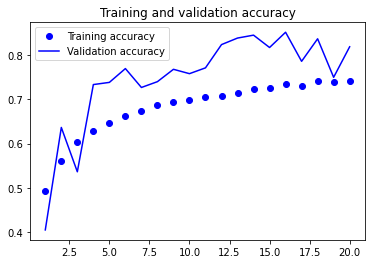

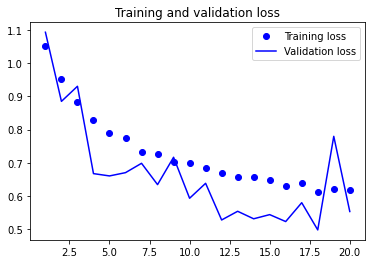

In [82]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

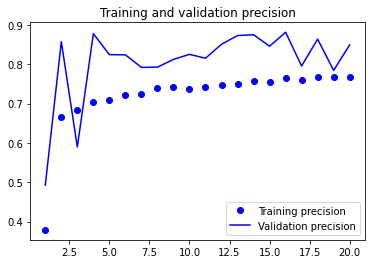

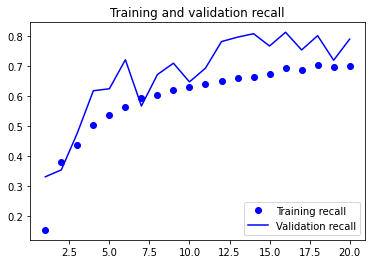

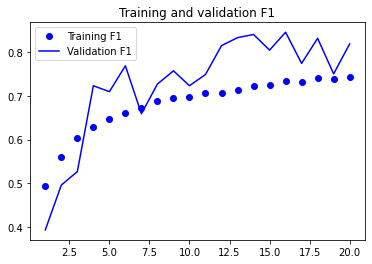

In [83]:
precision = history.history['precision_m']
recall = history.history['recall_m']
f1 = history.history['f1_m']
val_precision = history.history['val_precision_m']
val_recall = history.history['val_recall_m']
val_f1 = history.history['val_f1_m']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend()

plt.show()

# MORE HEAT MAPS

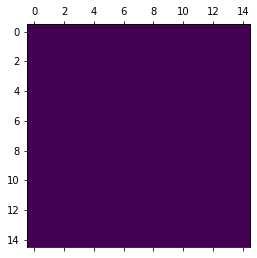

In [84]:
last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]



last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
# heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.matshow(heatmap)

In [ ]:
#SALIENCY

# sampling if needed

In [ ]:
bacterial_indices = np.array([i[0] == 1 and i[1] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 1 for i in y_train])
normal_indices = np.array([i[0] == 0 and i[1] == 0 for i in y_train])

print("train viral pneumonia cases: " + str(viral_indices.sum()))
print("train bacterial pneumonia cases: " + str(bacterial_indices.sum()))
print("train normal cases: " + str(normal_indices.sum()))

Since there is a significant imbalance of bacterial data compared to normal and viral data, we will be oversampling the normal and viral data accordingly.

In [ ]:
# prepare the oversampling data

X_train_normals, y_train_normals = X_train[normal_indices], y_train[normal_indices]
X_train_viral, y_train_viral = X_train[viral_indices], y_train[viral_indices]

In [ ]:
# in order for the data to be more or less equal, random sampling is used.
# viral and bacterial data will be oversampled to a size of 2500 in order to
# maintain an even ratio 

# this seed here is to maintain a deterministic runtime
np.random.seed(42)

normal_oversampling_indices = np.random.choice(X_train_normals.shape[0], 2500 - X_train_normals.shape[0])
viral_oversampling_indices = np.random.choice(X_train_viral.shape[0], 2500 - X_train_viral.shape[0])

print(normal_oversampling_indices)
print(viral_oversampling_indices)

In [ ]:
X_train_concatenate_normal, y_train_concatenate_normal = X_train_normals[normal_oversampling_indices], y_train_normals[normal_oversampling_indices]
X_train_concatenate_viral, y_train_concatenate_viral = X_train_viral[viral_oversampling_indices], y_train_viral[viral_oversampling_indices]

# new X_train
X_train = np.concatenate((X_train, X_train_concatenate_normal), axis=0)
X_train = np.concatenate((X_train, X_train_concatenate_viral))


# new Y_train
y_train = np.concatenate((y_train, y_train_concatenate_normal))
y_train = np.concatenate((y_train, y_train_concatenate_viral))

print(X_train.shape)

The proportions of the data have now been rebalanced to a relatively equal distribution.

In [ ]:
bacterial_indices = np.array([i[0] == 1 and i[1] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 1 for i in y_train])
normal_indices = np.array([i[0] == 0 and i[1] == 0 for i in y_train])

print("train viral pneumonia cases: " + str(viral_indices.sum()))
print("train bacterial pneumonia cases: " + str(bacterial_indices.sum()))
print("train normal cases: " + str(normal_indices.sum()))

In [ ]:
# rudimentary CNN for the three-way classification
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(2,activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
# todo: heatmaps! heatmaps! heatmaps! might turn the heatmaps into a whole function unto itself.

classifier_layer_names = [
    "dense_1"
]
img_array = preprocess_input(get_img_array(img_path, size = (299, 299)))

last_conv_layer = model.get_layer("block14_sepconv2_act")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
# for layer_name in classifier_layer_names:
#     x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    # print(preds[:, top_pred_index])
    top_class_channel = preds[:]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

print(pooled_grads.shape)

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.matshow(heatmap)